# Contents:


*   [About Data](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)
*   [Data Preprocessing](#prep)
*   [Exploratory Data Analysis](#eda)
*   [Hypothesis Testing](#hypo)
*   [Time Series Analysis](#TSA)
*   [Conclusion](#conc)




# Libraries:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_1samp, ttest_ind, pearsonr, spearmanr
import random

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.compat.pandas import Appender


from pmdarima import auto_arima


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data:

In [5]:
hourly_df = pd.read_csv('/content/drive/MyDrive/Bike-Sharing-Dataset/hour.csv')

In [6]:
hourly_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [7]:
hourly_df.shape

(17379, 17)

In [8]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [9]:
hourly_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [10]:
hourly_df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


<a name="prep"></a>
# Data Preprocessing:

In [11]:
# make copy of data:
df = hourly_df.copy()

In [12]:
# for seasons:
seasons_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}

# for year:
year_mapping = {0: 2011, 1: 2012}

# for weekday:
weekday_mapping = {0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday'}

# for weather:
weather_mapping = {1: 'clear', 2: 'cloudy', 3: 'light_rain_snow', 4: 'heavy_rain_snow'}

In [13]:
# apply encodings:

df.season = df.season.apply(lambda x: seasons_mapping[x])
df.yr = df.yr.apply(lambda x: year_mapping[x])
df.weekday = df.weekday.apply(lambda x: weekday_mapping[x])
df.weathersit = df.weathersit.apply(lambda x: weather_mapping[x])

In [14]:
# rescale humidaty and windspeed 
df.hum = df.hum * 100
df.windspeed = df.windspeed * 67

In [15]:
# check
df.sample(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
15620,15621,2012-10-18,fall,2012,10,1,0,thursday,1,clear,0.46,0.4545,82.0,15.0013,0,14,14
16242,16243,2012-11-14,fall,2012,11,12,0,wednesday,1,clear,0.34,0.3333,46.0,0.0000,40,200,240
11509,11510,2012-04-29,spring,2012,4,18,0,sunday,0,clear,0.60,0.6061,26.0,19.0012,164,323,487
1359,1360,2011-03-01,winter,2011,3,22,0,tuesday,1,clear,0.24,0.2727,62.0,7.0015,3,44,47
15210,15211,2012-09-30,fall,2012,9,23,0,sunday,0,clear,0.48,0.4697,72.0,6.0032,8,49,57


## validaing:

In [16]:
assert (df.casual + df.registered == df.cnt).all()

<a name="eda"></a>
#  EDA:

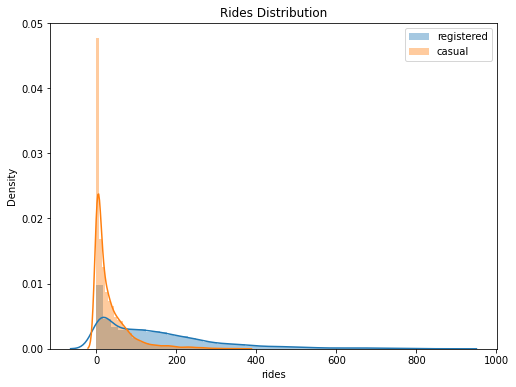

In [17]:
plt.figure(figsize = (8, 6))
sns.distplot(df.registered, label = 'registered')
sns.distplot(df.casual, label = 'casual')
plt.legend()
plt.xlabel('rides')
plt.title('Rides Distribution');

**See how rides rate change over time for both groups:**

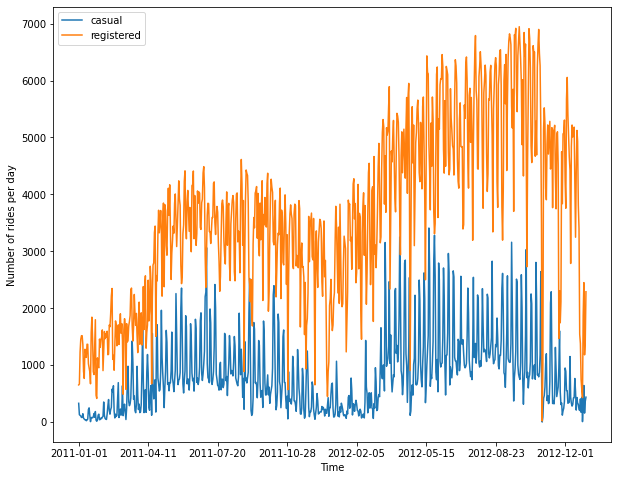

In [18]:
plot_data = df[['dteday', 'casual', 'registered']]
ax = plot_data.groupby('dteday').sum().plot(figsize = (10, 8))
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides per day');

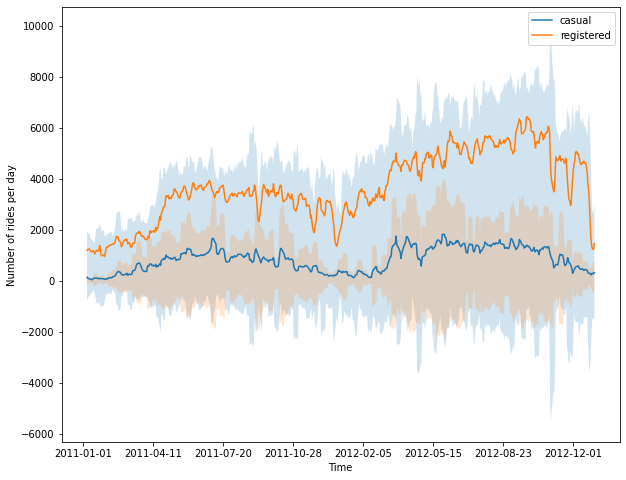

In [19]:
plot_data = plot_data.groupby('dteday').sum()
window = 7

rolling_means = plot_data.rolling(window).mean()
rolling_deviations = plot_data.rolling(window).std()

ax = rolling_means.plot(figsize = (10, 8))
ax.fill_between(rolling_means.index, rolling_means['registered'] + 2* rolling_deviations['registered'], 
                -2*rolling_deviations['registered'] , alpha = .2)
ax.fill_between(rolling_means.index, rolling_means['casual'] + 2* rolling_deviations['casual'], 
                -2*rolling_deviations['casual'] , alpha = .2)
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides per day');

## How rides request differ during day:

In [20]:
plot_data = df[['hr', 'weekday', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars=['hr', 'weekday'], var_name= 'type', value_name= 'count')
plot_data

,hr,weekday,type,count
0,0,saturday,registered,13
1,1,saturday,registered,32
2,2,saturday,registered,27
3,3,saturday,registered,10
4,4,saturday,registered,1
...,...,...,...,...
34753,19,monday,casual,11
34754,20,monday,casual,8
34755,21,monday,casual,7
34756,22,monday,casual,13


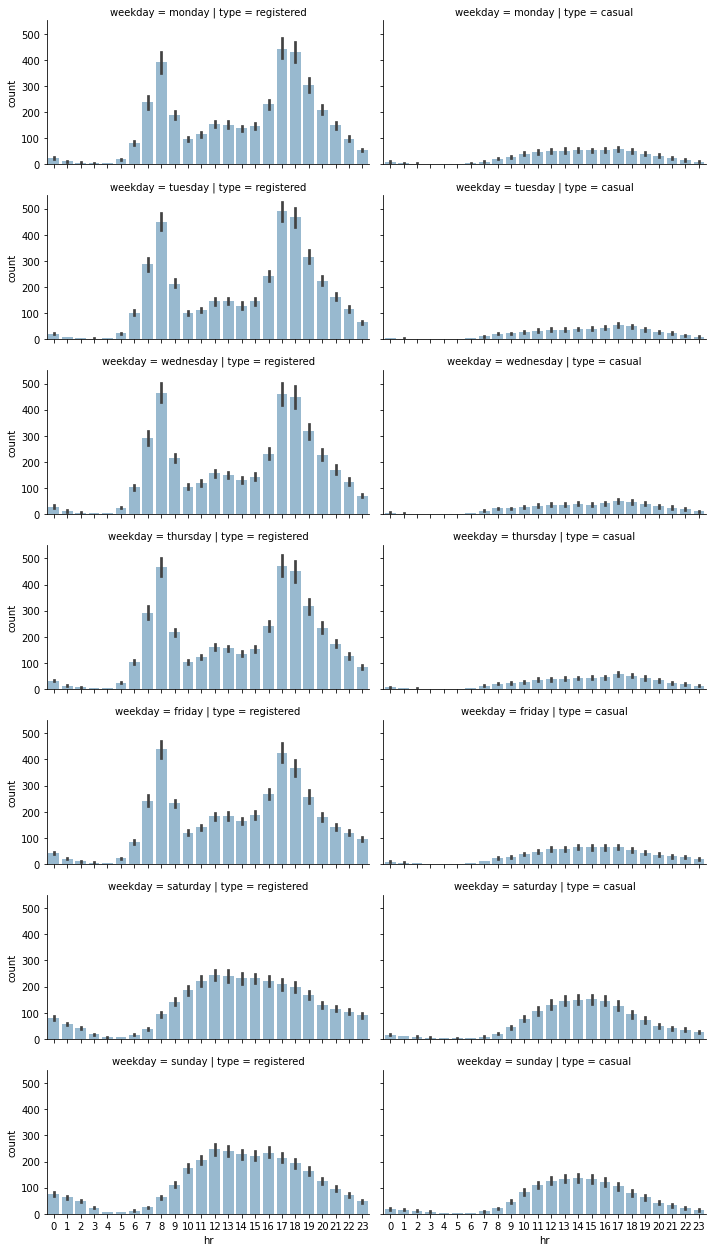

In [21]:
g = sns.FacetGrid(plot_data, col = 'type', row = 'weekday', row_order= ['monday', 'tuesday', 'wednesday', 'thursday', 
                                                       'friday', 'saturday', 'sunday'], height = 2.5, aspect  = 2)
g.map(sns.barplot, 'hr', 'count', alpha = .5);

## Is there a Seasonal Impact on rides:

In [22]:
plot_data = df[['hr', 'season', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars= ['hr', 'season'], var_name= 'type', value_name= 'count')
plot_data

,hr,season,type,count
0,0,winter,registered,13
1,1,winter,registered,32
2,2,winter,registered,27
3,3,winter,registered,10
4,4,winter,registered,1
...,...,...,...,...
34753,19,winter,casual,11
34754,20,winter,casual,8
34755,21,winter,casual,7
34756,22,winter,casual,13


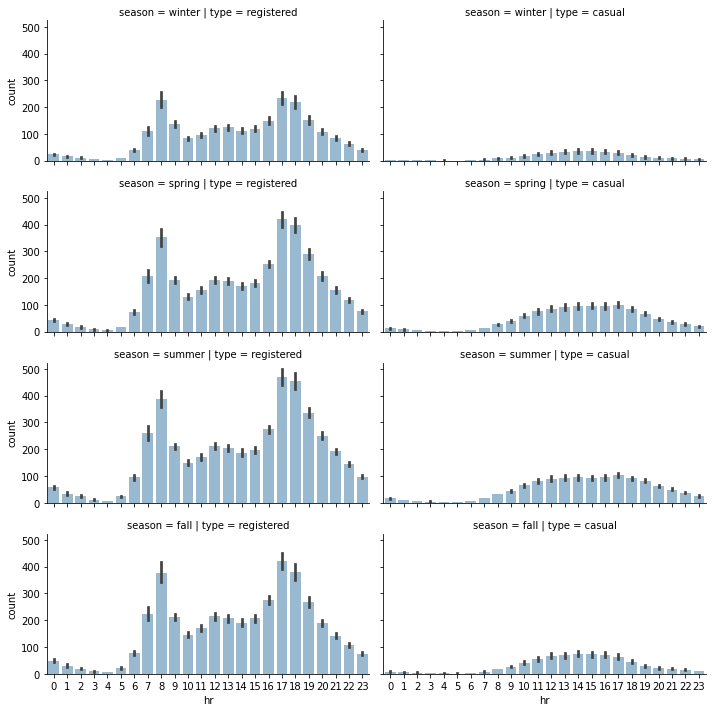

In [23]:
g2 = sns.FacetGrid(plot_data, col = 'type', row = 'season', height = 2.5, aspect = 2, row_order = ['winter', 'spring', 'summer', 'fall'])
g2.map(sns.barplot, 'hr', 'count', alpha = .5)

In [24]:
plot_data = df[['weekday', 'season', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars= ['weekday', 'season'], var_name = 'type', value_name = 'count')
plot_data

,weekday,season,type,count
0,saturday,winter,registered,13
1,saturday,winter,registered,32
2,saturday,winter,registered,27
3,saturday,winter,registered,10
4,saturday,winter,registered,1
...,...,...,...,...
34753,monday,winter,casual,11
34754,monday,winter,casual,8
34755,monday,winter,casual,7
34756,monday,winter,casual,13


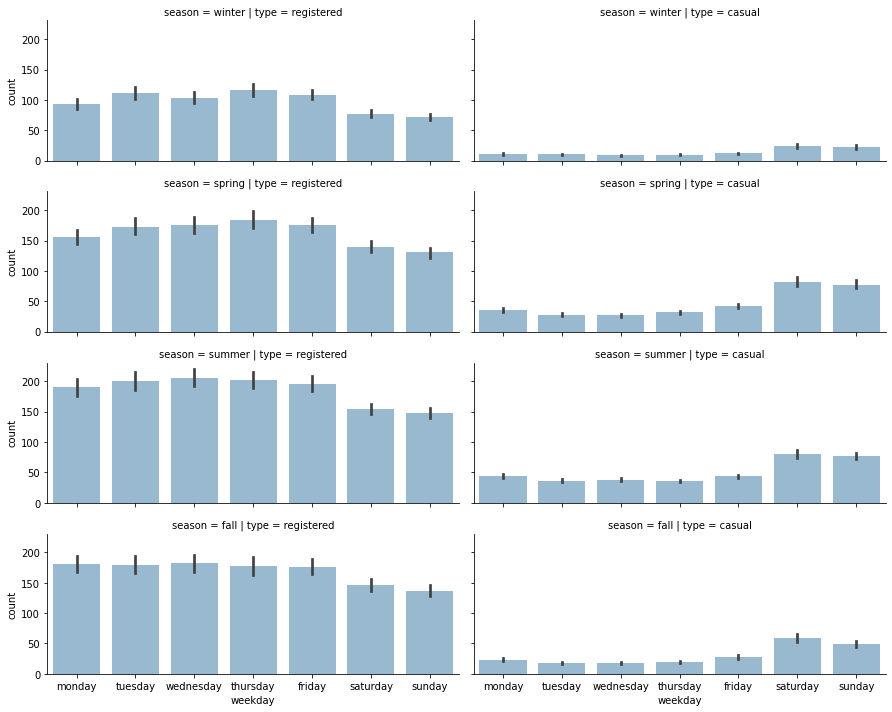

In [25]:
g3 = sns.FacetGrid(plot_data, col = 'type', row = 'season', height = 2.5, aspect = 2.5, row_order = ['winter', 'spring', 'summer', 'fall'])
g3.map(sns.barplot, 'weekday', 'count', alpha = .5, order = ['monday', 'tuesday', 'wednesday', 'thursday', 
                                                       'friday', 'saturday', 'sunday']);

## Analysis of weather related features:

In [33]:
def plot_correlations(data, col):
  # between col and registered rides
  corr_r = np.corrcoef(data[col], data.registered)[0, 1]
  ax = sns.regplot(x = col, y = 'registered', data = data, 
                   scatter_kws= {'alpha': .05},
                                 label = f"Registered rides (correlation: {corr_r:.3f})")
  # between col and casual rides
  corr_c = np.corrcoef(data[col], data.casual)[0, 1]
  ax = sns.regplot(x = col, y = 'casual', data = data, 
                   scatter_kws= {'alpha': .05},
                                 label = f"Casual rides (correlation: {corr_c:.3f})")
  legend = ax.legend()
  for lh in legend.legendHandles:
    lh.set_alpha(.5)
  ax.set_xlabel('Rides')
  ax.set_title(f"Correlation between rides and {col}")
  return ax

  

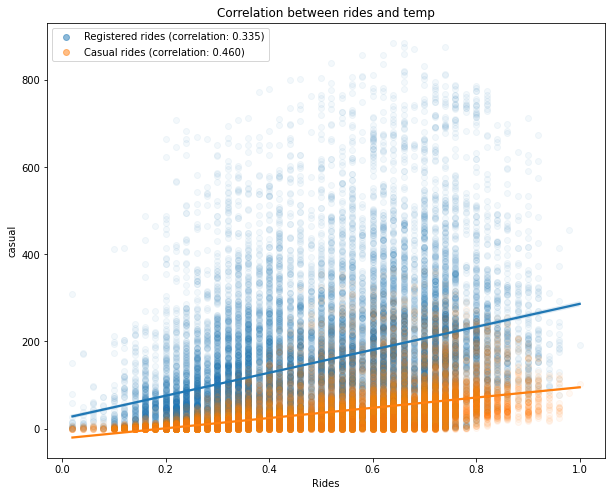

In [34]:
plt.figure(figsize=(10, 8))
ax = plot_correlations(df, 'temp')

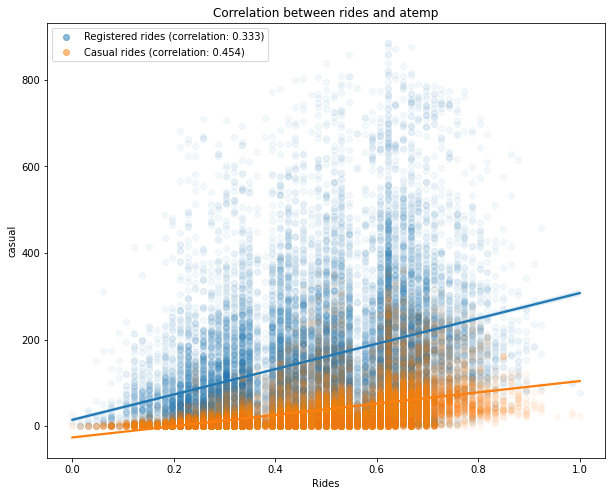

In [35]:
plt.figure(figsize=(10, 8))
ax = plot_correlations(df, 'atemp')

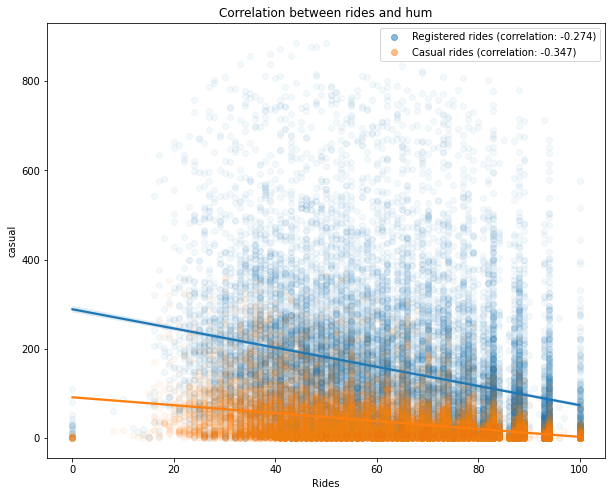

In [36]:
plt.figure(figsize=(10, 8))
ax = plot_correlations(df, 'hum')

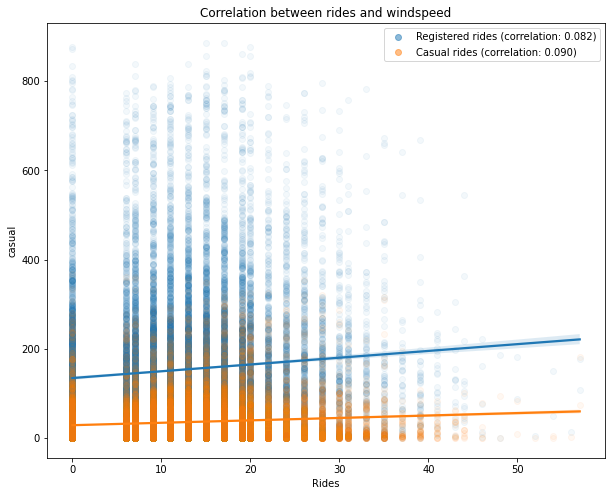

In [37]:
plt.figure(figsize=(10, 8))
ax = plot_correlations(df, 'windspeed')

In [45]:
def create_regression_plot(data, col, weather_cond):
   # extract data for the specifc weather condition
    plot_data = data[data['weathersit'] == weather_cond]
    # create regplot for registered users
    ax = sns.regplot(x=col, y="registered", data=plot_data, \
                     scatter_kws={"alpha":0.05})
    # create regplot for casual users
    ax = sns.regplot(x=col, y="casual", data=plot_data, \
                     scatter_kws={"alpha":0.05})
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{col} | {weather_cond}")

    return ax


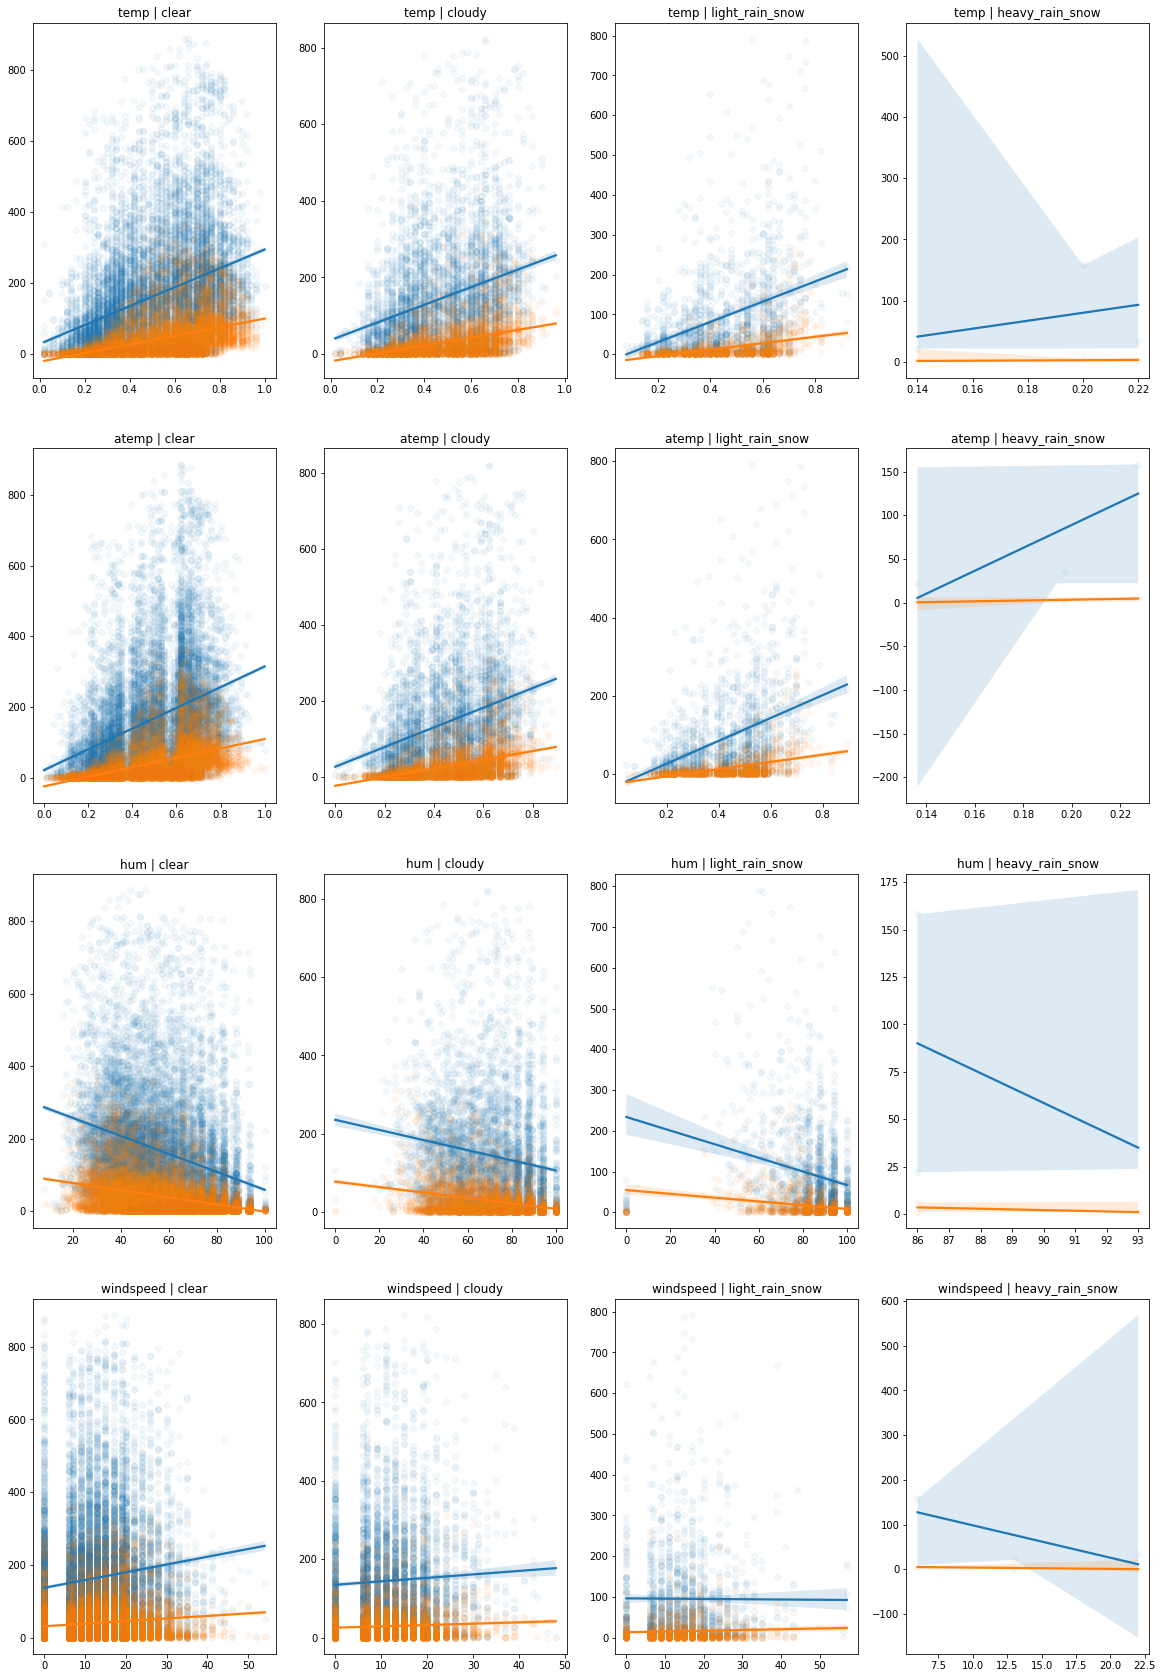

In [46]:
weather_conds = df.weathersit.unique()
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(20,30))
for col_index, col in enumerate(cols):
    for row_index, weather_cond in enumerate(weather_conds):
        plot_number = row_index + col_index*4 + 1
        plt.subplot(4,4,plot_number)
        create_regression_plot(df, col, weather_cond)

In [53]:
def print_correlations(data, col, weather_cond):
    # extract data for the specifc weather condition
    corr_data = data[data['weathersit'] == weather_cond]
     # compute pearson correlation between col and registered rides
    pearson_corr_r = pearsonr(corr_data[col], \
                              corr_data["registered"])
    # compute pearson correlation between col and casual rides
    pearson_corr_c = pearsonr(corr_data[col], corr_data["casual"])
    # print correlations
    print(f"Pearson correlation (registered, {col}, {weather_cond}): corr={pearson_corr_r[0]:.03f}, pval={pearson_corr_r[1]:.03f}")
    print(f"Pearson correlation (casual, {col}, {weather_cond}): corr={pearson_corr_c[0]:.03f}, pval={pearson_corr_c[1]:.03f}")

In [54]:
for col in cols:
    for weather_cond in weather_conds:
        print_correlations(df, col, weather_cond)

Pearson correlation (registered, temp, clear): corr=0.340, pval=0.000
Pearson correlation (casual, temp, clear): corr=0.459, pval=0.000
Pearson correlation (registered, temp, cloudy): corr=0.285, pval=0.000
Pearson correlation (casual, temp, cloudy): corr=0.437, pval=0.000
Pearson correlation (registered, temp, light_rain_snow): corr=0.356, pval=0.000
Pearson correlation (casual, temp, light_rain_snow): corr=0.433, pval=0.000
Pearson correlation (registered, temp, heavy_rain_snow): corr=0.360, pval=0.766
Pearson correlation (casual, temp, heavy_rain_snow): corr=0.277, pval=0.821
Pearson correlation (registered, atemp, clear): corr=0.334, pval=0.000
Pearson correlation (casual, atemp, clear): corr=0.451, pval=0.000
Pearson correlation (registered, atemp, cloudy): corr=0.285, pval=0.000
Pearson correlation (casual, atemp, cloudy): corr=0.434, pval=0.000
Pearson correlation (registered, atemp, light_rain_snow): corr=0.366, pval=0.000
Pearson correlation (casual, atemp, light_rain_snow): c

## show difference between pearson and spearman:

In [ ]:
def compute_correlations(data, col):
    pearson_reg = pearsonr(data[col], data["registered"])[0]
    pearson_cas = pearsonr(data[col], data["casual"])[0]
    spearman_reg = spearmanr(data[col], data["registered"])[0]
    spearman_cas = spearmanr(data[col], data["casual"])[0]
    return pd.Series({"Pearson (registered)": pearson_reg,\
                      "Spearman (registered)": spearman_reg,\
                      "Pearson (casual)": pearson_cas,\
                      "Spearman (casual)": spearman_cas})
    

In [ ]:
cols = ['temp', 'atemp', 'hum', 'windspeed']

corr_data = pd.DataFrame(index = ["Pearson (registered)", \
                                "Spearman (registered)",\
                                "Pearson (casual)", \
                                "Spearman (casual)"])

for col in cols:
    corr_data[col]=compute_correlations(df, col)
corr_data.T

,Pearson (registered),Spearman (registered),Pearson (casual),Spearman (casual)
temp,0.335361,0.373196,0.459616,0.570989
atemp,0.332559,0.373014,0.454080,0.570419
hum,-0.273933,-0.338480,-0.347028,-0.388213
windspeed,0.082321,0.122936,0.090287,0.122920


**We can say that casual users tend to use bike sharing system more when temperature is higher more than registered users.**

<a name="hypo"></a>
# Hypothesis Testing:

our significance level will be 5%.

Null Hypothesis: the average number of rides for registered users during weekdays is the same as the average number of rides during the weekend.

Alternamtive: there is a difference between average number of rides in weekdays and weekend. 

## for registered users:

In [26]:
weekends = ['saturday', 'sunday']
weekend_mask = df.weekday.isin(weekends)
working_mask = ~df.weekday.isin(weekends)

In [27]:
weekend_data = df.registered[weekend_mask]
workingdays_data= df.registered[working_mask]

In [28]:
test_res = ttest_ind(weekend_data, workingdays_data)
print(f"Test statistics: {test_res[0]}, p-value: {test_res[1]} ")

Test statistics: -16.003634921919275, p-value: 3.0911815856939266e-57 


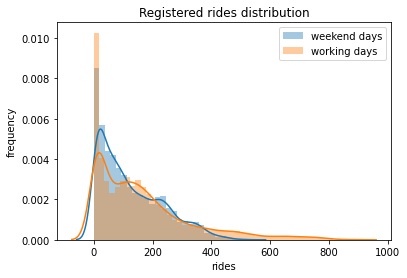

In [29]:
sns.distplot(weekend_data, label = 'weekend days')
sns.distplot(workingdays_data, label = 'working days')
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title('Registered rides distribution');

**There is a statistically significant difference between rides rate between weekdays and weekend for registered users, so we reject the null hypothesis.**

## Testing the same hypothesis for casual users:

In [30]:
cas_weekend_data = df.casual[weekend_mask]
cas_working_data = df.casual[working_mask]

In [31]:
test_res2 = ttest_ind(cas_weekend_data, cas_working_data)
print(f"Test statistics: {test_res2[0]}, p-value: {test_res2[1]} ")

Test statistics: 41.07674471273155, p-value: 0.0 


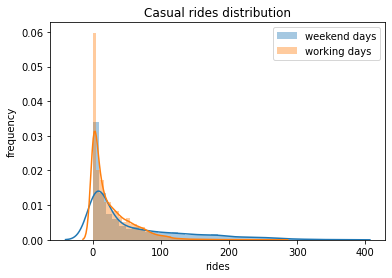

In [32]:
sns.distplot(cas_weekend_data, label = 'weekend days')
sns.distplot(cas_working_data, label = 'working days')
plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title('Casual rides distribution');

**We have strong evidence against the null hypothesis. Casual users behave differently over the weekend (use bike service more).**

<a name="TSA"></a>
# Time Series Analysis:

In [ ]:
# test stationarity:
def test_stationarity(ts, window=10, **kwargs):
# create dataframe for plotting
    plot_data = pd.DataFrame(ts)
    plot_data['rolling_mean'] = ts.rolling(window).mean()
    plot_data['rolling_std'] = ts.rolling(window).std()
    # compute p-value of Dickey-Fuller test
    p_val = adfuller(ts)[1]
    ax = plot_data.plot(**kwargs)
    ax.set_title(f"Dickey-Fuller p-value: {p_val:.3f}")

In [ ]:
daily_rides = df[["dteday", "registered", \
                                 "casual"]]
daily_rides = daily_rides.groupby("dteday").sum()
# convert index to DateTime object
daily_rides.index = pd.to_datetime(daily_rides.index)

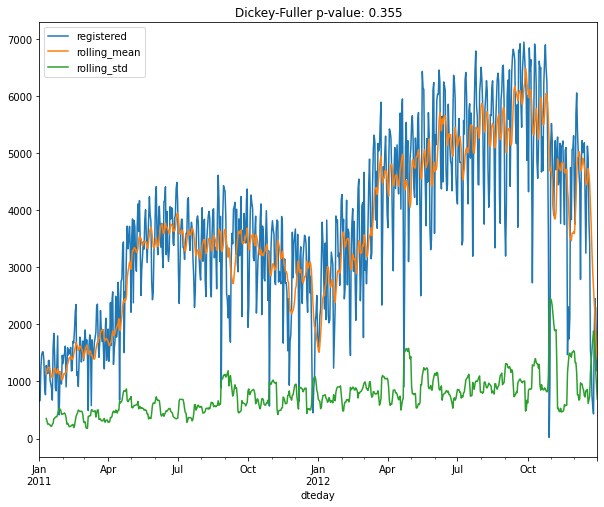

In [ ]:
test_stationarity(daily_rides.registered, figsize = (10, 8))

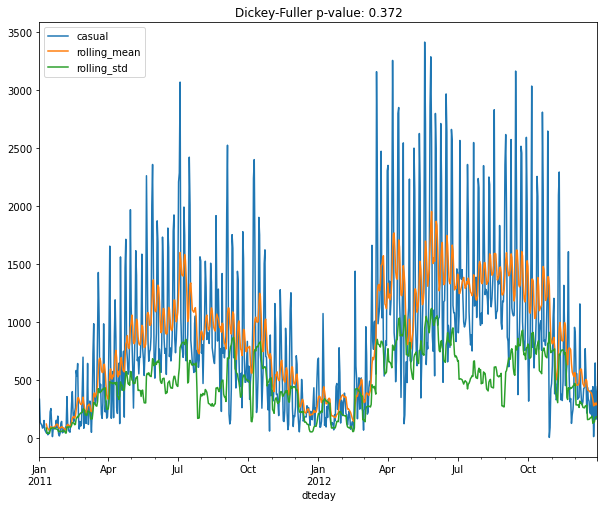

In [ ]:
test_stationarity(daily_rides.casual, figsize = (10, 8))

**Both rolling statistics and augmented dickey fuller test indicate that we have non stationary time series data**

## Convert to stationary by moving average

In [ ]:
# convert to stationary TS:
# for registered users
registered = daily_rides.registered
registered_ma = registered.rolling(10).mean()

registered_ma_diff = registered - registered_ma
registered_ma_diff.dropna(inplace = True)

# for casual users
casual = daily_rides.casual
casual_ma = casual.rolling(10).mean()

casual_ma_diff = casual - casual_ma
casual_ma_diff.dropna(inplace = True)


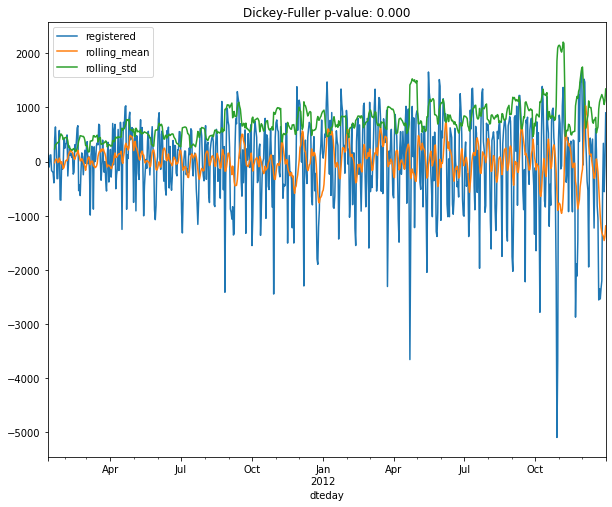

In [ ]:
test_stationarity(registered_ma_diff, figsize = (10, 8))

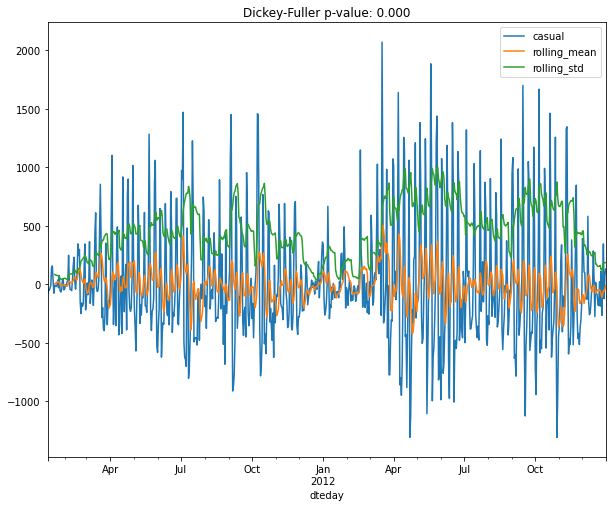

In [ ]:
test_stationarity(casual_ma_diff, figsize = (10, 8))

## Converting to stationary by decomposition:

In [ ]:
registered_decomposition = seasonal_decompose(\
                           daily_rides["registered"])
casual_decomposition = seasonal_decompose(daily_rides["casual"])

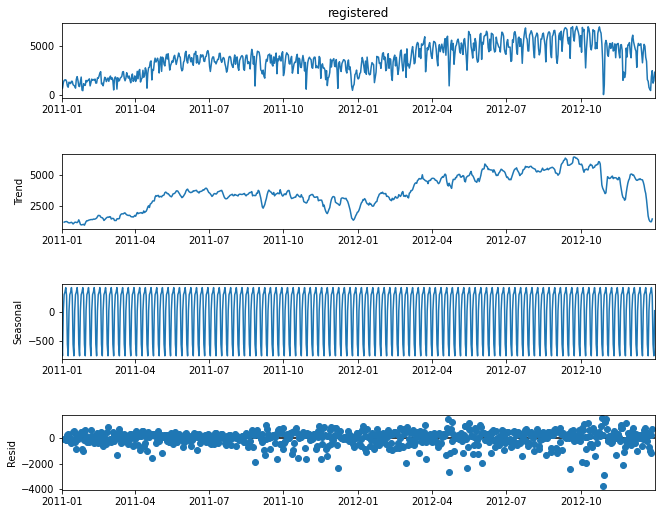

In [ ]:
registered_plot = registered_decomposition.plot()
registered_plot.set_size_inches(10, 8);


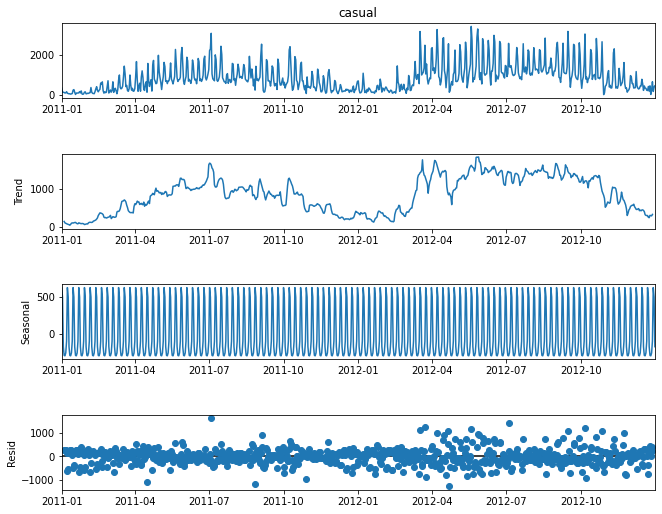

In [ ]:
casual_plot = casual_decomposition.plot()
casual_plot.set_size_inches(10, 8);

<Figure size 432x288 with 0 Axes>

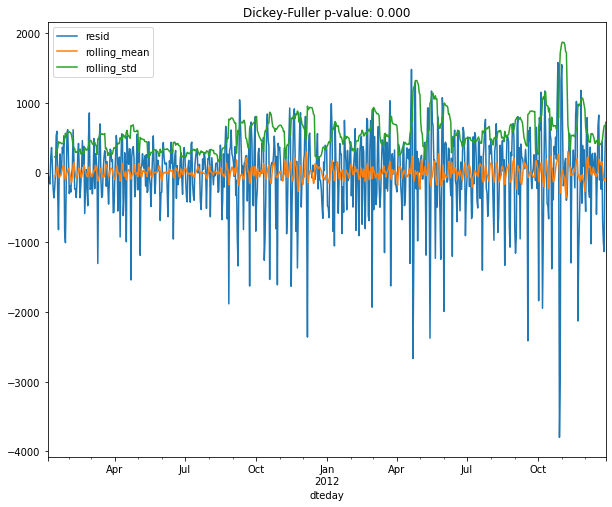

In [ ]:
# test residuals for stationarity
plt.figure()
test_stationarity(registered_decomposition.resid.dropna(), \
                  figsize=(10, 8))

<Figure size 432x288 with 0 Axes>

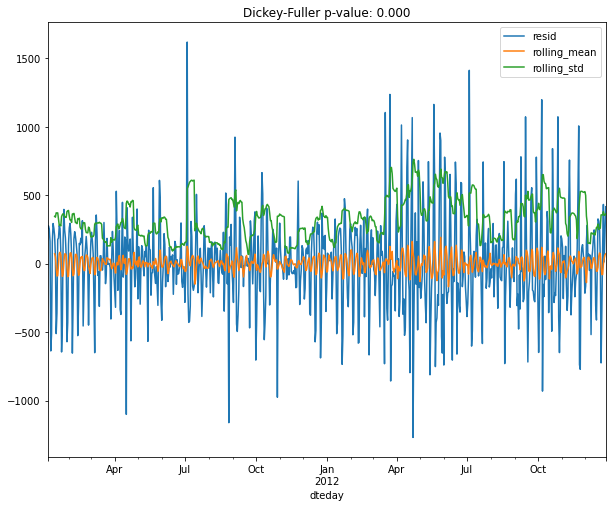

In [ ]:
plt.figure()
test_stationarity(casual_decomposition.resid.dropna(), \
                  figsize=(10, 8))

**The residuals satisfy stationarity**

## ARIMA Model:

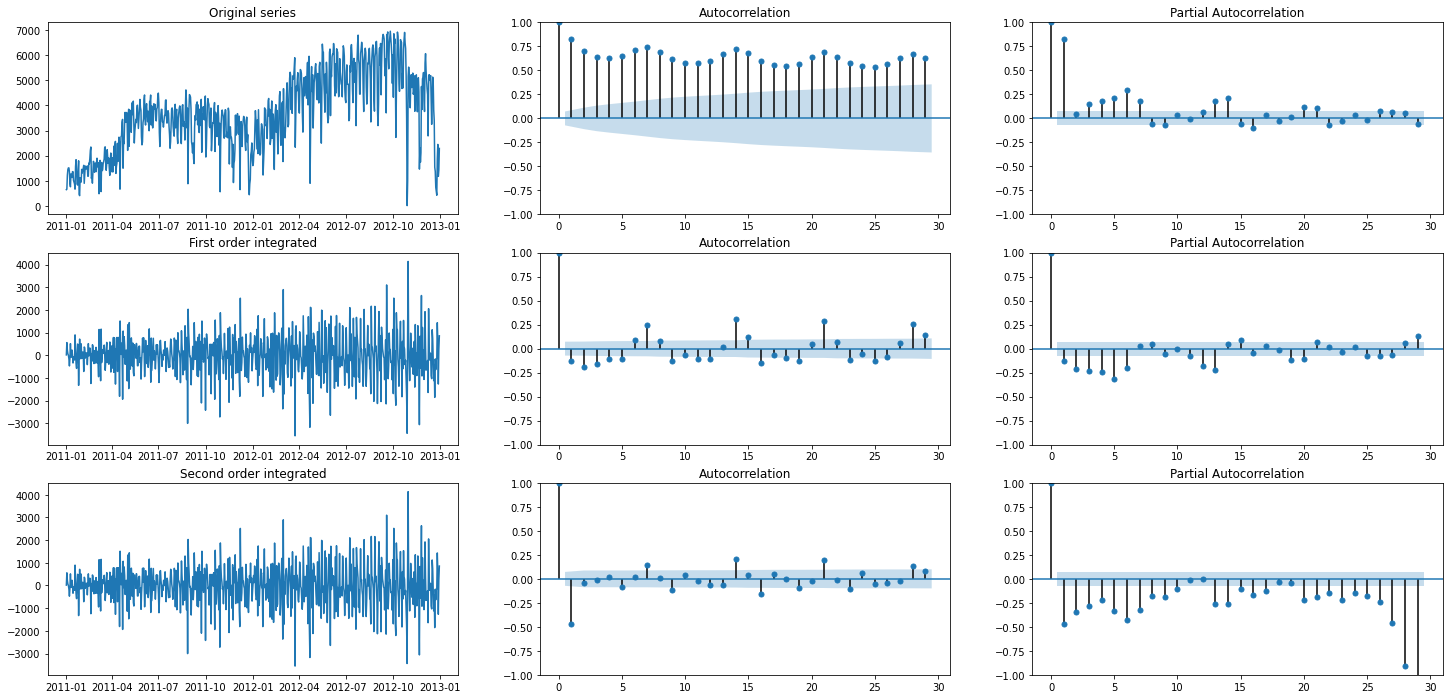

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
# plot original series
original = daily_rides["registered"]
axes[0,0].plot(original)
axes[0,0].set_title("Original series")
plot_acf(original, ax=axes[0,1])
plot_pacf(original, ax=axes[0,2])

# plot frst order integrated series
first_order_int = original.diff().dropna()
axes[1,0].plot(first_order_int)
axes[1,0].set_title("First order integrated")
plot_acf(first_order_int, ax=axes[1,1])
plot_pacf(first_order_int, ax=axes[1,2])

# plot frst order integrated series
second_order_int = first_order_int.diff().dropna()
axes[2,0].plot(first_order_int)
axes[2,0].set_title("Second order integrated")
plot_acf(second_order_int, ax=axes[2,1])
plot_pacf(second_order_int, ax=axes[2,2])
plt.show()

In [ ]:
model = auto_arima(registered, start_p=1, start_q=1, \
                   max_p=3, max_q=3, information_criterion="aic")
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5854.539
Date:                Fri, 01 Jul 2022   AIC                          11723.077
Time:                        15:49:10   BIC                          11755.229
Sample:                             0   HQIC                         11735.481
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6081      0.050     32.256      0.000       1.510       1.706
ar.L2         -1.4481      0.062    -23.255      0.000      -1.570      -1.326
ar.L3          0.3613      0.049      7.368      0.0

### Using in sample prediction to validate the model:

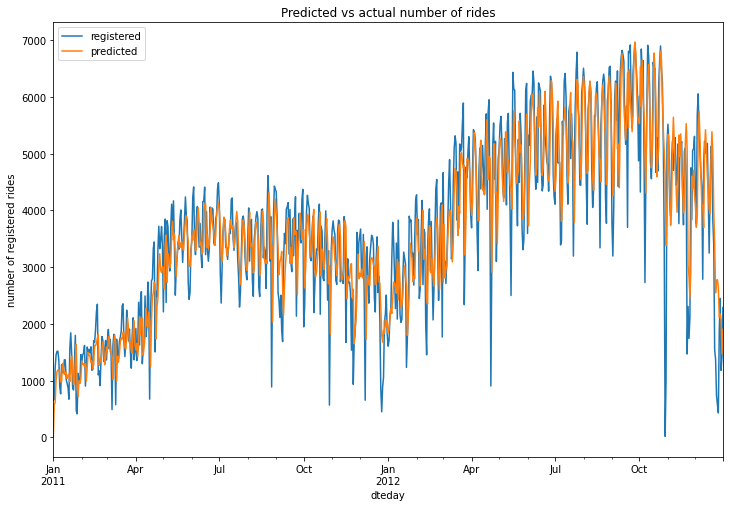

In [ ]:
# plot original and predicted values
plot_data = pd.DataFrame(registered)
plot_data['predicted'] = model.predict_in_sample()
plot_data.plot(figsize=(12, 8))
plt.ylabel("number of registered rides")
plt.title("Predicted vs actual number of rides");

<a name="conc"></a>
# Conclusion:


*   Registered users make more rides than casual users.
*   Total rides decreases in winter ( weather can have an impact on riding bikes rate).
*   For registerd users: days from monday to friday have a very similar patterns with two peaks( 8 am, 5 pm), however in saturday and sunday no peaking hours. (can be that users uses bikes to go to work).
*   For casual users: the rate for working days is lower than of weekend days.
*   Both registered and casual users have a low riding rate in winter than other seasons.
*   For registerd users:We proved that there there is a decreasing rate for rides over weekend.
*   For casual users: We proved that there is an increasing rate for rides over weekend.







